# Assignment 3  - AI tools 

Karl Lenberg & Kailash de Jesus Hornig

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np

from scipy.special import expit
import matplotlib.pyplot as plt

In [ ]:
# merge data into one dataframe and add names 
beijing = pd.read_csv('Beijing_labeled.csv')
beijing['City']='beijing'

chengdu = pd.read_csv('Chengdu_labeled.csv')
chengdu['City']='chengdu'

guangzhou = pd.read_csv('Guangzhou_labeled.csv')
guangzhou['City']='guangzhou'

shanghai = pd.read_csv('Shanghai_labeled.csv')
shanghai['City']='shanghai'

shenyang = pd.read_csv('Shenyang_labeled.csv')
shenyang['City']='shenyang'

merge_data = pd.concat([beijing,chengdu,guangzhou,shanghai, shenyang])

print(merge_data)

     season  DEWP   HUMI    PRES  TEMP     Iws  precipitation  cbwd_NE  \
0       4.0  -8.0  79.00  1026.0  -5.0   23.69            0.0        0   
1       4.0 -11.0  85.00  1021.0  -9.0  105.93            1.1        0   
2       4.0 -21.0  43.00  1030.0 -11.0  117.55            0.0        0   
3       4.0 -25.0  33.00  1034.0 -12.0   39.35            0.0        1   
4       4.0 -24.0  30.00  1034.0 -10.0   59.00            0.0        1   
..      ...   ...    ...     ...   ...     ...            ...      ...   
819     4.0 -22.0  50.63  1038.0 -14.0    4.00            0.0        0   
820     4.0 -16.0  52.47  1034.0  -8.0    4.00            0.0        0   
821     4.0 -13.0  45.91  1028.0  -3.0   40.00            0.0        0   
822     4.0  -4.0  80.04  1029.0  -1.0    6.00            0.0        0   
823     4.0  -8.0  79.42  1033.0  -5.0    4.00            0.0        0   

     cbwd_NW  cbwd_SE  PM_HIGH      City  
0          0        1      1.0   beijing  
1          0        1    

## Exploring the data for the cities

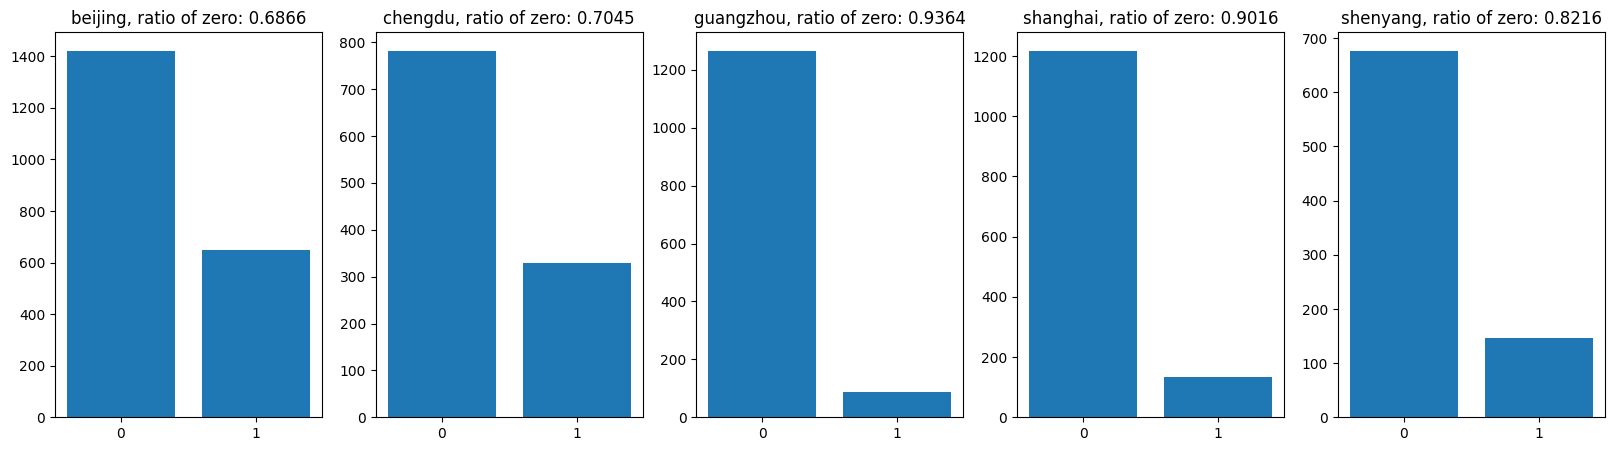

In [ ]:
city_names = merge_data["City"].unique()

fig, axs = plt.subplots(nrows=1, ncols=len(city_names), figsize=(20, 5))

for i, city in enumerate(city_names):
    mask = merge_data["City"] == city
    
    # Count the number of ones and zeros for the current city
    one = merge_data[mask]["PM_HIGH"].sum()
    zero = merge_data[mask].shape[0] - one

    ratio_zero = np.round(zero/(one+zero),4)
    
    axs[i].bar(["0","1"], [zero, one])
    axs[i].set_title(city+', ratio of zero: '+str(ratio_zero))


plt.show()


## Defining helper methods

In [ ]:
def get_city_data(city,data = merge_data):
    data_copy = data.copy()
    return data_copy[data_copy['City'].isin(city)].drop('City', axis=1).astype(float)

def standardize_data(data):
    data_copy = data.copy()
    for col in (list(data_copy.columns.values)[:-1]):
        data_copy[col]=(data_copy[col] - data_copy[col].mean() ) / data_copy[col].std()
    return data_copy

def normalize_data(data):
    data_copy = data.copy()
    for col in (list(data_copy.columns.values)[:-1]):
        data_copy[col] = (data_copy[col] - data_copy[col].min()) / (data_copy[col].max() - data_copy[col].min())    
    return data_copy

def split_data(data, test_size = 0.2):
    X = data.drop('PM_HIGH', axis=1).to_numpy()
    y = data['PM_HIGH']
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=test_size, random_state=42)
    return  X_train, X_test, y_train, y_test

# K-means classifier

In [ ]:
class KMClassifier():
    def __init__(self, k = 15):
        #Initiate k
        self.k = k 
        #Initiate clustering method
        self.kmeans = KMeans(n_clusters=self.k)
        #Initiate cluster labels
        self.labels = None
        
    def fit(self, X_train, y_train):
        self.kmeans.fit(X_train)
        labels = np.zeros(self.k)

        for i in range(self.k):
            #Obtain assignment for each sample
            mask = (self.kmeans.labels_ == i) 
            #Find majority class in each label
            labels[i] = np.bincount(y_train[mask]).argmax()
        self.labels = labels
        
    def predict(self, X_test):
        cluster_assignments = self.kmeans.predict(X_test)
        return self.labels[cluster_assignments]
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test) 
        return accuracy_score(y_test,y_pred)


In [ ]:
results = []

for city in ['beijing','chengdu', 'guangzhou', 'shanghai', 'shenyang']:
    city_data = get_city_data([city])
    normalized = normalize_data(city_data)
    standardized = standardize_data(city_data)
    all_data= {'Original data': city_data,'Standardized data':standardized,'Normalized data':normalized}
    
    for data in ['Original data', 'Standardized data','Normalized data']:
        for k in range(2,30):
            X_train, X_test, y_train, y_test = split_data(all_data[data])
            clf = KMClassifier(k)
            clf.fit(X_train,y_train)
            acc = clf.score(X_test, y_test)
            results.append([city,acc,data,k])

results_df = pd.DataFrame(results, columns = ['City','Accuracy','Data','k'])
results_df = results_df.loc[results_df.groupby('City')['Accuracy'].idxmax()]
print(results_df)

          City  Accuracy               Data   k
19     beijing  0.768675      Original data  21
109    chengdu  0.788288      Original data  27
168  guangzhou  0.933579      Original data   2
252   shanghai  0.918819      Original data   2
390   shenyang  0.860606  Standardized data  28


# Training & testing

### Optimizing Beijing & Shenyang

In [1]:
results = []

city_data = get_city_data(['beijing','shenyang'])
normalized = normalize_data(city_data)
standardized = standardize_data(city_data)

all_data= {'Original data': city_data,'Standardized data':standardized,'Normalized data':normalized}

for data in ['Original data', 'Standardized data','Normalized data']:
    for k in range(2,50):
        X_train, X_test, y_train, y_test = split_data(all_data[data])
        clf = KMClassifier(k)
        clf.fit(X_train,y_train)
        val_acc = clf.score(X_test, y_test)
        train_acc = clf.score(X_train, y_train)
        results.append([val_acc,train_acc,k,data])

results_df = pd.DataFrame(results, columns = ['Validation Accuracy','Training Accuracy','k', 'Data'])


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 5))

for j, acc in enumerate(['Validation Accuracy','Training Accuracy']):
    for i, data in enumerate(['Original data', 'Standardized data','Normalized data']):
        # Create a mask for the current city
        mask = results_df["Data"] == data
        
        # Count the number of ones and zeros for the current city
        accuracy = results_df[mask][acc]
        k = results_df[mask]['k']
        
        # Plot a bar chart for the current city
        axs[j][i].plot(k, accuracy)
        axs[j][i].set_title(acc +' '+ data)

#fig.tight_layout()

NameError: name 'get_city_data' is not defined

### Optimizing Guangzhou & shanghai

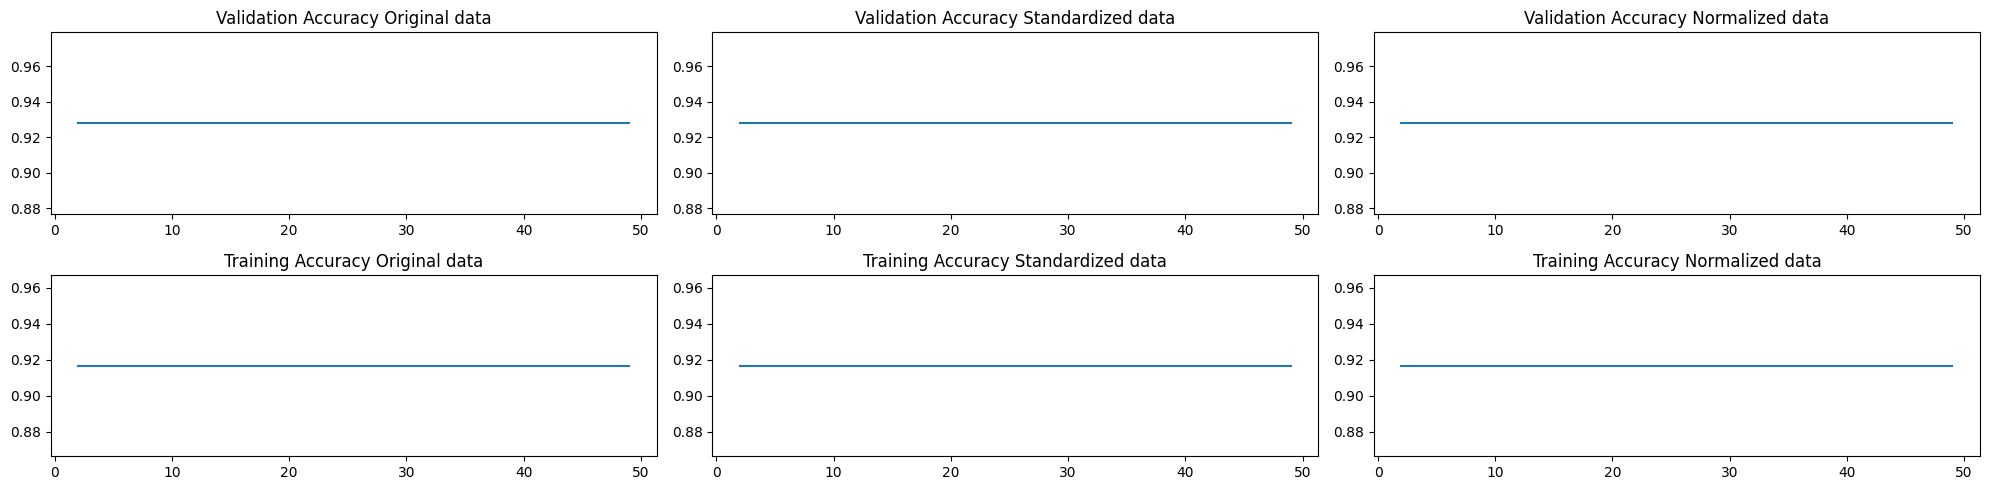

In [ ]:
results = []

city_data = get_city_data(['guangzhou','shanghai'])
normalized = normalize_data(city_data)
standardized = standardize_data(city_data)

all_data= {'Original data': city_data,'Standardized data':standardized,'Normalized data':normalized}

for data in ['Original data', 'Standardized data','Normalized data']:
    for k in range(2,50):
        X_train, X_test, y_train, y_test = split_data(all_data[data])
        clf = KMClassifier(k)
        clf.fit(X_train,y_train)
        val_acc = clf.score(X_test, y_test)
        train_acc = clf.score(X_train, y_train)
        results.append([val_acc,train_acc,k,data])

results_df = pd.DataFrame(results, columns = ['Validation Accuracy','Training Accuracy','k', 'Data'])


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 5))

for j, acc in enumerate(['Validation Accuracy','Training Accuracy']):
    for i, data in enumerate(['Original data', 'Standardized data','Normalized data']):
        # Create a mask for the current city
        mask = results_df["Data"] == data
        
        # Count the number of ones and zeros for the current city
        accuracy = results_df[mask][acc]
        k = results_df[mask]['k']
        
        # Plot a bar chart for the current city
        axs[j][i].plot(k, accuracy)
        axs[j][i].set_title(acc +' '+ data)

fig.tight_layout()

### Validating GS on model trained on BS

In [ ]:
results = []

train_data = standardize_data(get_city_data(['beijing','shenyang']))
test_data = standardize_data(get_city_data(['guangzhou','shanghai']))

X_train, y_train = train_data.drop(['PM_HIGH'], axis=1) , train_data['PM_HIGH']
X_test, y_test = test_data.drop(['PM_HIGH'], axis=1) , test_data['PM_HIGH']

clf = KMClassifier(45)
clf.fit(X_train,y_train)
val_acc = clf.score(X_test, y_test)
train_acc = clf.score(X_train, y_train)
results.append([val_acc,train_acc])

results_df = pd.DataFrame(results, columns = ['Validation Accuracy','Training Accuracy'])
print(results_df)

   Validation Accuracy  Training Accuracy
0             0.746578            0.77582


### Importance of features on all data

In [ ]:

all_data = merge_data
X = all_data.drop(['PM_HIGH','City'], axis=1)
X['all'] = np.zeros(len(X))
y = all_data['PM_HIGH']

results = []

for column in X.columns: 
    X_train, X_test, y_train, y_test = split_data(pd.concat([X.drop([column], axis=1), y], axis=1))
    clf = KMClassifier(40)
    clf.fit(X_train,y_train)
    val_acc = clf.score(X_test, y_test)
    train_acc = clf.score(X_train, y_train)
    results.append([column, val_acc,train_acc])

results_df = pd.DataFrame(results, columns = ['column', 'Validation Accuracy','Training Accuracy']).sort_values(by='Validation Accuracy', ascending=False)
print(results_df)



           column  Validation Accuracy  Training Accuracy
1            DEWP             0.807004           0.811032
8         cbwd_NW             0.807004           0.812523
3            PRES             0.804024           0.813455
4            TEMP             0.803279           0.805814
7         cbwd_NE             0.799553           0.811405
0          season             0.798063           0.810101
9         cbwd_SE             0.798063           0.811405
10            all             0.798063           0.809914
5             Iws             0.792101           0.806933
6   precipitation             0.792101           0.808423
2            HUMI             0.787630           0.807678


### Importance of features on Guangzhou & shanghai

In [ ]:
#Check accuracy when doing the prediction based on a single vector

all_data = get_city_data(['guangzhou','shanghai'])
X = all_data.drop(['PM_HIGH'], axis=1)
X['all'] = np.zeros(len(X))
y = all_data['PM_HIGH']

results = []

for column in X.columns: 
    X_train, X_test, y_train, y_test = split_data(pd.concat([X.drop([column], axis=1), y], axis=1))
    clf = KMClassifier(100)
    clf.fit(X_train,y_train)
    val_acc = clf.score(X_test, y_test)
    train_acc = clf.score(X_train, y_train)
    results.append([column, val_acc,train_acc])

results_df = pd.DataFrame(results, columns = ['column', 'Validation Accuracy','Training Accuracy']).sort_values(by='Validation Accuracy', ascending=False)
print(results_df)


print('Dummy: '+str(np.round(sum(pm == 0 for pm in y)/len(y),2)))

           column  Validation Accuracy  Training Accuracy
0          season             0.927911           0.916744
1            DEWP             0.927911           0.916744
2            HUMI             0.927911           0.916744
3            PRES             0.927911           0.916744
4            TEMP             0.927911           0.916744
5             Iws             0.927911           0.916744
6   precipitation             0.927911           0.916744
7         cbwd_NE             0.927911           0.916744
8         cbwd_NW             0.927911           0.916744
9         cbwd_SE             0.927911           0.916744
10            all             0.927911           0.916744
Dummy: 0.92


### Training model on equal Zero/One ratio

In [ ]:
df = merge_data

# Count the number of zeros and ones in PM_HIGH
zeros = sum(df['PM_HIGH'] == 0)
ones = sum(df['PM_HIGH'] == 1)

# Determine the number of rows to extract
n = min(zeros, ones)

# Extract the first n/2 rows where PM_HIGH is 0 and the next n/2 rows where PM_HIGH is 1
equal_data = df[df['PM_HIGH'] == 0][:n].append(df[df['PM_HIGH'] == 1][:n]).drop('City',axis=1)

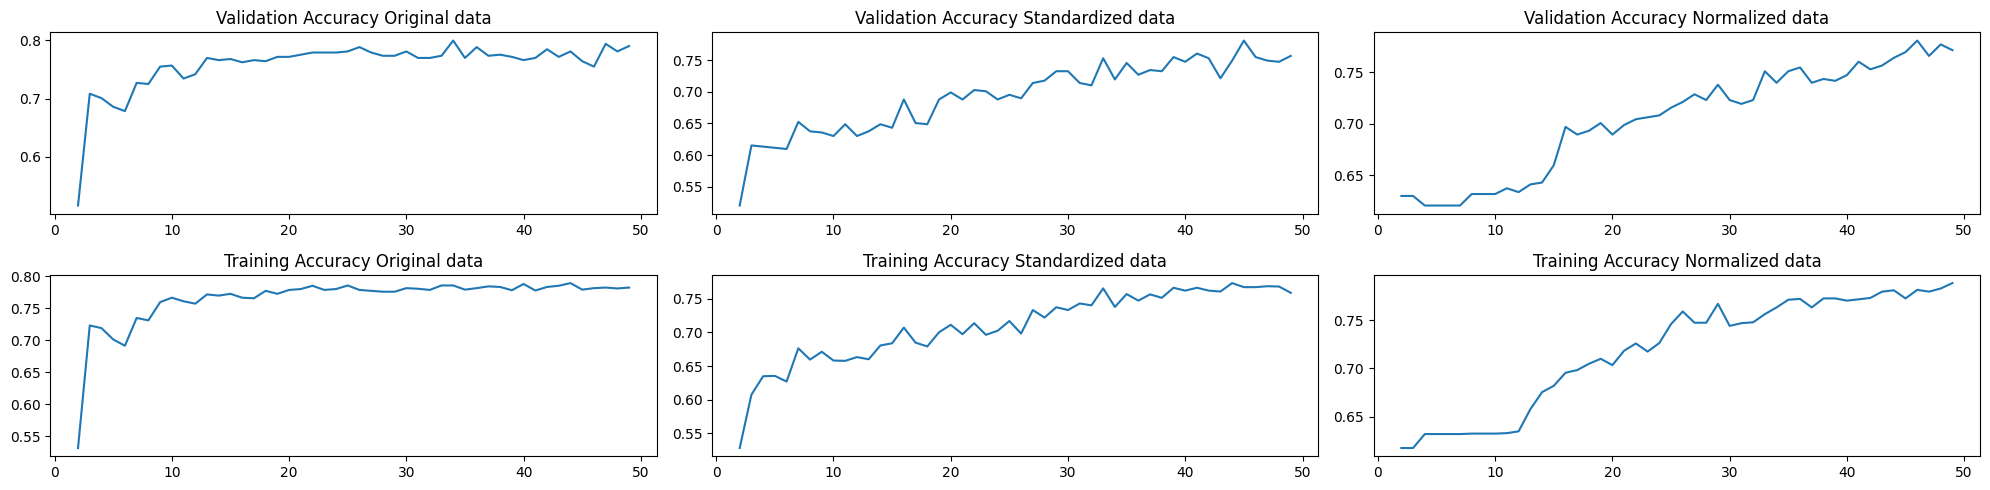

In [ ]:
results = []

city_data = equal_data
normalized = normalize_data(city_data)
standardized = standardize_data(city_data)

all_data= {'Original data': city_data,'Standardized data':standardized,'Normalized data':normalized}

for data in ['Original data', 'Standardized data','Normalized data']:
    for k in range(2,50):
        X_train, X_test, y_train, y_test = split_data(all_data[data])
        clf = KMClassifier(k)
        clf.fit(X_train,y_train)
        val_acc = clf.score(X_test, y_test)
        train_acc = clf.score(X_train, y_train)
        results.append([val_acc,train_acc,k,data])

results_df = pd.DataFrame(results, columns = ['Validation Accuracy','Training Accuracy','k', 'Data'])


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 5))

for j, acc in enumerate(['Validation Accuracy','Training Accuracy']):
    for i, data in enumerate(['Original data', 'Standardized data','Normalized data']):
        # Create a mask for the current city
        mask = results_df["Data"] == data
        
        # Count the number of ones and zeros for the current city
        accuracy = results_df[mask][acc]
        k = results_df[mask]['k']
        
        # Plot a bar chart for the current city
        axs[j][i].plot(k, accuracy)
        axs[j][i].set_title(acc +' '+ data)

fig.tight_layout()

In [ ]:
results = []

train_data = equal_data
test_data = get_city_data(['beijing','shenyang'])

X_train, y_train = train_data.drop(['PM_HIGH'], axis=1) , train_data['PM_HIGH']
X_test, y_test = test_data.drop(['PM_HIGH'], axis=1) , test_data['PM_HIGH']

clf = KMClassifier(45)
clf.fit(X_train,y_train)
val_acc = clf.score(X_test, y_test)
train_acc = clf.score(X_train, y_train)
results.append([val_acc,train_acc])

results_df = pd.DataFrame(results, columns = ['Validation Accuracy','Training Accuracy'])
print(results_df)

   Validation Accuracy  Training Accuracy
0             0.689119           0.788161


In [ ]:
## Best accuracy achieved on orignal data K = 45

results = []

train_data = equal_data
test_data = get_city_data(['guangzhou','shanghai'])

X_train, y_train = train_data.drop(['PM_HIGH'], axis=1) , train_data['PM_HIGH']
X_test, y_test = test_data.drop(['PM_HIGH'], axis=1) , test_data['PM_HIGH']

clf = KMClassifier(45)
clf.fit(X_train,y_train)
val_acc = clf.score(X_test, y_test)
train_acc = clf.score(X_train, y_train)
results.append([val_acc,train_acc])

results_df = pd.DataFrame(results, columns = ['Validation Accuracy','Training Accuracy'])
print(results_df)

   Validation Accuracy  Training Accuracy
0             0.280799           0.781087


# LogisticRegression classifier

In [ ]:
import numpy as np

class LogisticRegression():
    def __init__(self, learning_rate=0.01, max_iter=100):
        self.weights = None
        self.learning_rate = learning_rate
        self.max_iter = max_iter
    
    def _sigmoid(self, x):
        return 1 / (1 + expit(-x))

    def fit(self, X_train, y_train):
        X_train = np.insert(X_train, 0, 1, axis=1)
        self.weights = np.zeros(X_train.shape[1])
        
        for _ in range(self.max_iter):
            y_pred = self._sigmoid(X_train.dot(self.weights))
            error = y_train - y_pred
            gradient = X_train.T.dot(error)
            self.weights += self.learning_rate * gradient

    def predict(self, X_test):
        X_test = np.insert(X_test, 0, 1, axis=1)
        y_pred = self._sigmoid(X_test.dot(self.weights))
        return (y_pred > 0.5).astype(int)

    def score(self, X_test, y_test):
        y_pred_bin = self.predict(X_test)
        return np.sum(y_test == y_pred_bin)/len(y_test)

In [ ]:
results = []

for city in ['beijing','chengdu', 'guangzhou', 'shanghai', 'shenyang']:
    city_data = get_city_data([city])
    normalized = normalize_data(city_data)
    standardized = standardize_data(city_data)
    all_data= {'Original data': city_data,'Standardized data':standardized,'Normalized data':normalized}
    
    for data in ['Original data', 'Standardized data','Normalized data']:
        for lr in [0.05,0.01,0.001]:
            for max_iter in [100,500,1000]:
                X_train, X_test, y_train, y_test = split_data(all_data[data])
                clf = LogisticRegression(learning_rate=lr,max_iter=max_iter)
                clf.fit(X_train, y_train)
                acc = clf.score(X_test, y_test)
                results.append([city,acc,data,lr,max_iter])

results_df = pd.DataFrame(results, columns = ['City','Accuracy','Data','Learning_rate','Max iterations'])
results_df = results_df.loc[results_df.groupby('City')['Accuracy'].idxmax()]
print(results_df)

          City  Accuracy               Data  Learning_rate  Max iterations
16     beijing  0.732530  Standardized data          0.001             500
37     chengdu  0.770270  Standardized data          0.050             500
54   guangzhou  0.933579      Original data          0.050             100
81    shanghai  0.918819      Original data          0.050             100
120   shenyang  0.854545  Standardized data          0.010             100


# K-nearest neighbours Classifier

In [ ]:
class KNN():
    def __init__(self, k = 1, dist = 'euclidian'):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.dist = dist
    
    def fit(self, x, y):
        self.X_train = x
        self.y_train = y

    def distance(self,x1,x2):
        if self.dist == 'euclidian':
            return np.sqrt(np.sum((x1 - x2)**2, axis=1))
        
        elif self.dist == 'manhattan':
            return np.sum(np.abs(x1 - x2), axis=1)
        
        else:
            print('Error: faulty distance measure')

    def predict(self, X_test):
        y_pred = np.zeros(X_test.shape[0])
        for i, x in enumerate(X_test):  
            distances = self.distance(self.X_train, x) 
            nearest_neighbors = np.argsort(distances)[:self.k] 
            y_neighbors = self.y_train.iloc[nearest_neighbors]
            y_pred[i] = np.bincount(y_neighbors).argmax()
        return y_pred
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return accuracy_score(y_test,y_pred)
        


In [ ]:
results = []

for city in ['beijing','chengdu', 'guangzhou', 'shanghai', 'shenyang']:
    city_data = get_city_data([city])
    normalized = normalize_data(city_data)
    standardized = standardize_data(city_data)
    all_data= {'Original data': city_data,'Standardized data':standardized,'Normalized data':normalized}
    
    for data in ['Original data', 'Standardized data','Normalized data']:
        for k in range(2,30):
            for dist in ['euclidian','manhattan']:
                X_train, X_test, y_train, y_test = split_data(all_data[data])
                clf = KNN(k=k, dist = dist)
                clf.fit(X_train,y_train)
                acc = clf.score(X_test, y_test)
                results.append([city,acc,data,k,dist])

results_df = pd.DataFrame(results, columns = ['City','Accuracy','Data','k','Distance Model'])
results_df = results_df.loc[results_df.groupby('City')['Accuracy'].idxmax()]
print(results_df)

          City  Accuracy               Data   k Distance Model
34     beijing  0.780723      Original data  19      euclidian
259    chengdu  0.810811  Standardized data  19      manhattan
341  guangzhou  0.937269      Original data   4      manhattan
630   shanghai  0.933579    Normalized data   9      euclidian
757   shenyang  0.854545  Standardized data  16      manhattan


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9c52a5d0-b452-40c9-bc0a-977a02670dfa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>